In [1]:
# imports
# deconv library
from FastLZeroSpikeInference import fast

# some classic things
import numpy as np
import os

# to load and save matfiles
import scipy
import mat73

In [2]:
# this function mostly copied from
# https://stackoverflow.com/questions/15436318/traversing-a-dictionary-recursively
def get_dict_item(dic,target_key = 'Fc'):
    for k,v in dic.items():
        if isinstance(v,dict):
            for k1,v1 in get_dict_item(v,target_key):
                yield (k,)+k1, v1
        else:
            if k == target_key:
                yield (k,),v

# some function definition
def get_traces(dat, target_key):
    key_chain = []
    traces = []
    # The thing with this get_dict_item function is it uses yield instead 
    # of return, so it is a generator object. 
    # So I can only repeatly run this code if I intialize it as an object.
    gen_object = get_dict_item(dat,target_key)
    for p,v in gen_object:
        key_chain += [p]
        traces += [v]

    return key_chain, traces





In [3]:
# loop through the files and find what is needed (But what? I think I need the fluroscent traces?)

# goto the directory with my data files
start_dir = '/mnt/lilyDrive/sharedFieldAnalysis/CombGUITrack_raw'
save_dir = '/mnt/lilyDrive/sharedFieldAnalysis/combGUITrack_deconv'

# get a filelist.
files = os.listdir(start_dir)
filepath = [os.path.join(start_dir,f) for f in files]

# temporary, I want to work with an exmaple filepath
filepath = [filepath[4]]

# batch loop for later use
for i,f in enumerate(filepath):
    dat = mat73.loadmat(f)
    key_chain, traces =  get_traces(dat, 'Fc')
    print(len)
    

ERROR: MATLAB type not supported: table, (uint32)
ERROR: MATLAB type not supported: table, (uint32)
ERROR: MATLAB type not supported: table, (uint32)
<built-in function len>


In [4]:
test_dat = dat['gui_behav']
key_chain, traces =  get_traces(dat, 'Fc')
print(key_chain)

[('gui_rois', 'coreg', 'dSPN', 'Fc'), ('gui_rois', 'coreg', 'iSPN', 'Fc'), ('gui_rois', 'nocoreg', 'dSPN', 'Fc'), ('gui_rois', 'nocoreg', 'iSPN', 'Fc'), ('track_rois', 'coreg', 'dSPN', 'Fc'), ('track_rois', 'coreg', 'iSPN', 'Fc'), ('track_rois', 'nocoreg', 'dSPN', 'Fc'), ('track_rois', 'nocoreg', 'iSPN', 'Fc')]


In [5]:
print(key_chain)

[('gui_rois', 'coreg', 'dSPN', 'Fc'), ('gui_rois', 'coreg', 'iSPN', 'Fc'), ('gui_rois', 'nocoreg', 'dSPN', 'Fc'), ('gui_rois', 'nocoreg', 'iSPN', 'Fc'), ('track_rois', 'coreg', 'dSPN', 'Fc'), ('track_rois', 'coreg', 'iSPN', 'Fc'), ('track_rois', 'nocoreg', 'dSPN', 'Fc'), ('track_rois', 'nocoreg', 'iSPN', 'Fc')]


In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets

def plot_deconv(dff, est, events, times, i, frame_rate=30, ax = []):
    '''
    dff: dF/F NxT array
    est: deconvolution model fit NxT array
    events: event magnitudes, array of size N
    times: event frames/times, array of size N
    i: cell index
    T: length of timeseries (frames)
    frame_rate: default 30
    returns: holoview overlay of traces for single cell, for jupyter interactive notebook
    '''
    dff = dff[i, :]
    est = est[i, :]
    ev = events[i]
    times = times[i]

    # d = np.zeros(T)
    # d[times] = ev

    event_plot = times, -0.5 * np.ones(times.shape)
    #t = T / frame_rate
    # fig = plt.figure()
    if not ax:
      ax = plt.axes()
    ax.eventplot(event_plot,zorder=3,color='red')
    ax.plot(dff+0.5, label='Calcium', color='blue')

    return ax, dff.shape[0]

In [7]:
ct = traces[0]
print(ct.shape[0],ct.shape[1])

16753 54


In [8]:
# import functions that I need to run
from L0_deconv import fit_lambda, run_l0events

key_chain, traces = get_traces(dat,'Fc')
i = 0
ck = key_chain[i]
ct = traces[i].transpose()

# wantted to try different lambda and compare side to side
y = np.array(ct[3:5,:]) # (n,t) array n#traces, t#frames
l0 = fit_lambda(y,event_min_size = 3)
dec_l3 = run_l0events(l0,y)

# try lambda = 4
y = np.array(ct[3:5,:]) # (n,t) array n#traces, t#frames
l0 = fit_lambda(y,event_min_size = 4)
dec_l4 = run_l0events(l0,y)


# try lambda = 5
y = np.array(ct[3:5,:]) # (n,t) array n#traces, t#frames
l0 = fit_lambda(y,event_min_size = 5)
dec_l5 = run_l0events(l0,y)

Computing df/f..done!
Calculating events in progress
using bisection
0


/home/howelab/lily/L0_analysis.py:217: UserWarning: Genotype is unknown, assuming halflife of 270 ms
  warnings.warn('Genotype is unknown, assuming halflife of 270 ms')


right endpoint:16
finding lambda to minimize num events < min size
lambda = 0.070556640625
.using bisection
0
right endpoint:32
finding lambda to minimize num events < min size
lambda = 0.05609130859375
.done!
Computing df/f..done!
Calculating events in progress
using bisection
0
right endpoint:16
finding lambda to minimize num events < min size
lambda = 0.11407470703125
.using bisection
0
right endpoint:32
finding lambda to minimize num events < min size
lambda = 0.10015869140625
.done!
Computing df/f..done!
Calculating events in progress
using bisection
0
right endpoint:16
finding lambda to minimize num events < min size
lambda = 0.16754150390625
.using bisection
0
right endpoint:32
finding lambda to minimize num events < min size
lambda = 0.1607666015625
.done!


In [9]:
dec_l3.keys()

dict_keys(['dff', 'est', 'times', 'events', 'gamma', 'lambda'])

In [10]:
# try converting spike train into an array of 1s and 0s.

print(dec_l3['est'].shape)
print(dec_l3['dff'].shape)
times_long = np.zeros(dec_l3['dff'].shape)
events_long = np.zeros(dec_l3['dff'].shape)
#ind = np.transpose([[x,i] for i in dec_l3['times'][i] for x in range(len(dec_l3['times']))])
for r in range(len(dec_l3['times'])):
    c_idx = dec_l3['times'][r]
    r_idx = np.ones(c_idx.shape,dtype='int') * r
    times_long[r_idx,c_idx] = 1
    events_long[r_idx,c_idx] = dec_l3['events'][r]
# times_long[ind[0],ind[1]] = 1
# events_long[ind[0],ind[1]] = dec_l3['events']

(2, 16753)
(2, 16753)


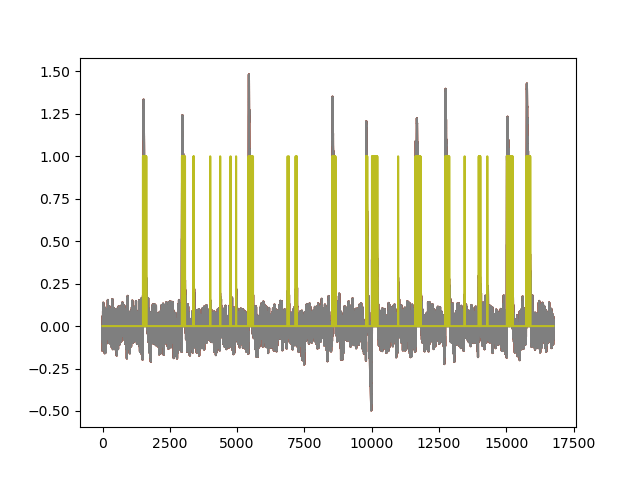

In [15]:
plt.plot(dec_l3['dff'][1,:])
plt.plot(times_long[1,:])
plt.show()

interactive(children=(FloatSlider(value=0.0, description='Frame', max=14753.0), Output()), _dom_classes=('widg…

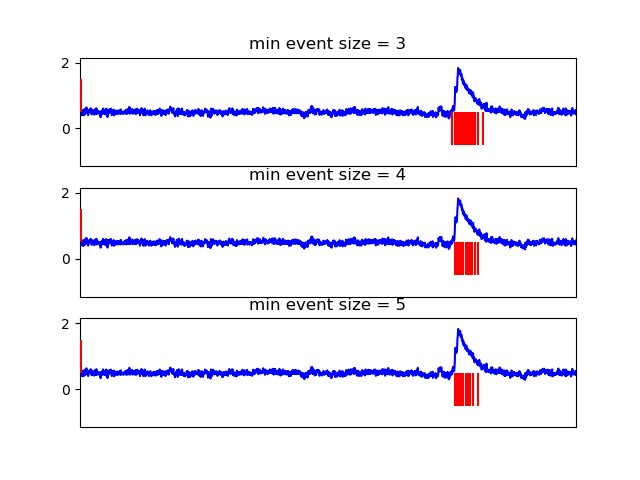

In [12]:
# quick plotting to evaluate result of deconv
#%matplotlib ipympl
%matplotlib widget
from ipywidgets import interact

plt.ioff()
fig, (ax1, ax2,ax3) = plt.subplots(3,1)
fig.canvas.header_visible = False
_, dff_len = plot_deconv(dec_l3['dff'],dec_l3['est'],dec_l3['events'],dec_l3['times'],1, ax = ax1)
plot_deconv(dec_l4['dff'],dec_l4['est'],dec_l4['events'],dec_l4['times'],1, ax=ax2)
plot_deconv(dec_l5['dff'],dec_l5['est'],dec_l5['events'],dec_l5['times'],1, ax=ax3)
ax1.set_title('min event size = 3')
ax2.set_title('min event size = 4')
ax3.set_title('min event size = 5')
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
disp_span = 2000

plt.ion()
def update_xlim(val):
    ax1.set_xlim(val,val+disp_span)
    ax2.set_xlim(val,val+disp_span)
    ax3.set_xlim(val,val+disp_span)


interact(update_xlim,val = widgets.FloatSlider(value=0,min=0,max=dff_len-disp_span,
                                                description = 'Frame',
                                                orientation ='horizontal',
                                                ))
plt.show()



In [14]:
dat['gui_rois'].keys()

dict_keys(['coreg', 'nocoreg'])